In [7]:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics                     # to get sliding history stats in N*logN instead of N^2
from pyabc import SingleCoreSampler

import seaborn as sns

ERROR:External:Install rpy2 to enable simple support for the R language.


Define auxiliary functions for SSs:

In [12]:
# Directionality ratio:
def distDR(R_data):
    D = 0
    N_total = len(R_data)
    Dr = np.zeros(N_total-1)
    for i in range(N_total-1):
        d = np.linalg.norm(R_data[i+1] - R_data[0])
        D += np.linalg.norm(R_data[i+1] - R_data[i])
        Dr[i] = d / D
    return Dr

# Radius of gyration:
def distRG(R_data, time_interval=100):
    """
    Calculates the radius of gyration for R_data corresponding to a single trajectory over time.
    # Data structure:
    -> R_data: N_steps x 2
    """
    N_total = len(R_data)
    Rg = np.zeros(N_total)
    for i in range(N_total-1):
        R_cm = sum(R_data[:i+2]) / (i+2)
        #print(R_cm)
        Rg[i+1] = (sum((R_data[:i+2] - R_cm)**2)).sum() / ((i+1)*time_interval)
    Rg[0] = 0
    return np.sqrt(Rg)

# Heterogeneity ratio:
def distHR(dataset_msd, time_interval=50):
    N = len(dataset_msd)
    M2 = np.zeros(N)
    HR = np.zeros(N)
    for i in range(N-1):
        M2[i+1] = np.var(dataset_msd[:i+2])
        #print(M2[i+1])
    HR[1:] = M2[1:]/dataset_msd[1:]**2
    return HR

Define all SS functions:

In [56]:
# Time-averaged mean square displacement:
def distanceMSD(val1, val2):
    diff = tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]])) - val2['IdSumstat__MSD']
    d = np.sqrt(np.sum(diff**2))
    return d

# Direction autocorrelation function:
def distanceVAC(val1, val2):
    diff = tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][t_init:],val1['IdSumstat__velocity.y'][t_init:]])) - val2['IdSumstat__VAC']
    d = np.sqrt(np.sum(diff**2))
    return d

# Directionality ratio:
def distanceDR(val1, val2):
    diff = distDR(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]])) - val2['IdSumstat__DR']
    d = np.sqrt(np.sum(diff**2))
    return d

# Radius of Gyration:
def distanceRG(val1, val2):
    R = distRG(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]]))
    d = np.sqrt(np.sum((R - val2['IdSumstat__RG'])**2))
    return d

# Heterogeneity ratio:
def distanceHR(val1, val2):
    diff = distHR(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]]))) - val2['IdSumstat__HR']
    d = np.sqrt(np.sum(diff**2))
    return d



Create "measured data" with each SS function.

In [8]:
file_ = "Demo_CellMotility.xml"
par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
           'noise_level': './Global/Constant[@symbol="noise_level"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    #executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}

MorpheusModel {
	name      : Demo_CellMotility.xml
}


In [15]:
N = 100
tot_time = 5
t_init = 1
arrayMSD = np.zeros((N, tot_time))
arrayVAC = np.zeros((N, tot_time))
arrayDR = np.zeros((N, tot_time-1))
arrayRG = np.zeros((N, tot_time))
arrayHR = np.zeros((N, tot_time))

for i in range(N):
    simulated_data = model.sample(true_pars)
    val1vec = np.column_stack([simulated_data['IdSumstat__cell.center.x'][t_init:],simulated_data['IdSumstat__cell.center.y'][t_init:]])
    val1vecmsd = tidynamics.msd(val1vec)
    arrayMSD[i] = val1vecmsd
    arrayVAC[i] = tidynamics.acf(np.column_stack([simulated_data['IdSumstat__velocity.x'][t_init:],simulated_data['IdSumstat__velocity.y'][t_init:]]))
    arrayDR[i] = distDR(val1vec)
    arrayRG[i] = distRG(val1vec)
    arrayHR[i] = distHR(val1vecmsd)

In [16]:
MSD = np.array([arrayMSD[:,i].mean() for i in range(5)])
VAC = np.array([arrayVAC[:,i].mean() for i in range(5)])
DR = np.array([arrayDR[:,i].mean() for i in range(4)])
RG = np.array([arrayRG[:,i].mean() for i in range(5)])
HR = np.array([arrayHR[:,i].mean() for i in range(5)])
measured_data = {'IdSumstat__time': np.array([0, 100, 200, 300, 400]),\
                 'IdSumstat__MSD': MSD,\
                 'IdSumstat__VAC':VAC,\
                 'IdSumstat__DR': DR,\
                 'IdSumstat__RG': RG,\
                 'IdSumstat__HR': HR}

In [17]:
measured_data

{'IdSumstat__time': array([  0, 100, 200, 300, 400]),
 'IdSumstat__MSD': array([-1.44063961e-11,  1.32961072e+03,  4.17154345e+03,  7.15768304e+03,
         9.62810645e+03]),
 'IdSumstat__VAC': array([ 0.18938391,  0.07832915,  0.01327382, -0.0270964 , -0.02898262]),
 'IdSumstat__DR': array([1.        , 0.88730423, 0.78037545, 0.67007898]),
 'IdSumstat__RG': array([0.        , 2.83729963, 3.64838835, 4.16604039, 4.47876779]),
 'IdSumstat__HR': array([0.        , 0.25      , 0.17406237, 0.16304497, 0.41891339])}

## Define the pipeline as a function:

In [19]:
def fmc_mot_pipeline(file_name, t_init, time_interval, populations, dist_functions):
    file_ = file_name#"Demo_CellMotility.xml"
    par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
               'noise_level': './Global/Constant[@symbol="noise_level"]'}
    model = fmc.model.MorpheusModel(
        file_, par_map=par_map,
        #executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
        executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",
        show_stdout=False, show_stderr=True,
        raise_on_error=False)

    print(model)
    
    limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

    prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                                  for key, (lb, ub) in limits.items()})
    #true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
    distance = pyabc.AdaptiveAggregatedDistance(dist_functions, adaptive=False)
    
    abc = pyabc.ABCSMC(model, prior, distance, population_size=100)
    # Store specific db_path:
    db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
    history = abc.new(db_path, measured_data)
    abc.run(max_nr_populations=populations)
    h = pyabc.History(db_path)
    return h

## Test it works properly:

In [32]:
data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=1, dist_functions=[d1, d2])

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=25, start_time=2021-01-08 14:34:58.092331, end_time=None)>
INFO:ABC:Calibration sample before t=0.


MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.0003638579980012269
INFO:ABC:t: 0, eps: 0.0003638579980012269.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=25, start_time=2021-01-08 14:34:58.092331, end_time=2021-01-08 14:39:36.115165)>


/Users/sebas/opt/anaconda3/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


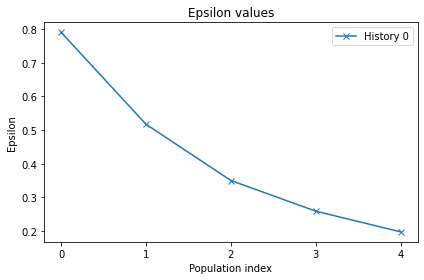

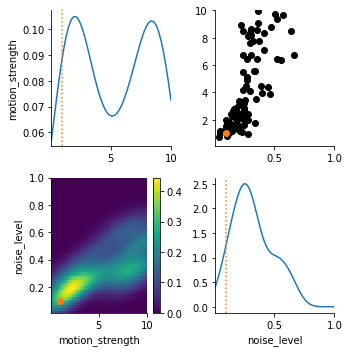

In [24]:
#h = pyabc.History(db_path)
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}
pyabc.visualization.plot_epsilons(data)
df, w = data.get_distribution(t=4)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

## Now the juicy part: loop over SSs:

In [ ]:
# Extensions of SS functions:
ss_list = ['MSD', 'VAC', 'DR', 'RG', 'HR']
#ss_list = ['MSD', 'VAC']

for el1 in ss_list:
    measured_list = []
    for el2 in ss_list:
        measured_list.append(el2)
        if (el1 != el2) and (el1 not in measured_list):
            #print(el1,el2)
            functions_names = []
            d = el1 + '_' + el2
            functions_names.append('data_' + el1 + '_' + el2)
            #data = ['data%s' % os.join.el1]
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ',d)
            data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=6, dist_functions=distances)
            globals()['data_' + el1 + '_'+ el2] = data
        elif (el1 == el2):
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ', str(dist1))
            data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=6, dist_functions=distances[0])
            globals()['data_' + el1 + '_'+ el2] = data            


INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=29, start_time=2021-01-08 18:01:48.504423, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Working with  <function distanceMSD at 0x7f9e4d468940>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.35597474095762915
INFO:ABC:t: 0, eps: 0.35597474095762915.
INFO:ABC:Acceptance rate: 100 / 187 = 5.3476e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.25638708247961006.
INFO:ABC:Acceptance rate: 100 / 310 = 3.2258e-01, ESS=9.1201e+01.
INFO:ABC:t: 2, eps: 0.1674593504351176.
INFO:ABC:Acceptance rate: 100 / 628 = 1.5924e-01, ESS=8.7682e+01.
INFO:ABC:t: 3, eps: 0.11261338205716223.
INFO:ABC:Acceptance rate: 100 / 850 = 1.1765e-01, ESS=8.7673e+01.
INFO:ABC:t: 4, eps: 0.07535977271860164.
INFO:ABC:Acceptance rate: 100 / 1870 = 5.3476e-02, ESS=7.6920e+01.
INFO:ABC:t: 5, eps: 0.05194931103847468.
INFO:ABC:Acceptance rate: 100 / 3699 = 2.7034e-02, ESS=8.5492e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=29, start_time=2021-01-08 18:01:48.504423, end_time=2021-01-08 19:44:31.973448)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=30, start_time=2021-01-08 19:44:32.018334, end_time=None

Working with  VAC_MSD
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.717194070861069
INFO:ABC:t: 0, eps: 0.717194070861069.
INFO:ABC:Acceptance rate: 100 / 206 = 4.8544e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5791963468322906.
INFO:ABC:Acceptance rate: 100 / 308 = 3.2468e-01, ESS=7.6994e+01.
INFO:ABC:t: 2, eps: 0.46168079146165275.
INFO:ABC:Acceptance rate: 100 / 402 = 2.4876e-01, ESS=9.0676e+01.
INFO:ABC:t: 3, eps: 0.3468890710421109.
INFO:ABC:Acceptance rate: 100 / 630 = 1.5873e-01, ESS=8.4827e+01.
INFO:ABC:t: 4, eps: 0.26087952196456343.
INFO:ABC:Acceptance rate: 100 / 571 = 1.7513e-01, ESS=7.8185e+01.
INFO:ABC:t: 5, eps: 0.18038553957950162.
INFO:ABC:Acceptance rate: 100 / 1054 = 9.4877e-02, ESS=7.0579e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=30, start_time=2021-01-08 19:44:32.018334, end_time=2021-01-08 20:26:49.630748)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=31, start_time=2021-01-08 20:26:49.680277, end_time=None)>
INF

Working with  <function distanceVAC at 0x7f9e4d468dc0>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.4128439874817688
INFO:ABC:t: 0, eps: 0.4128439874817688.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.21235884160370153.
INFO:ABC:Acceptance rate: 100 / 272 = 3.6765e-01, ESS=8.8621e+01.
INFO:ABC:t: 2, eps: 0.13530824083880652.
INFO:ABC:Acceptance rate: 100 / 300 = 3.3333e-01, ESS=6.1046e+01.
INFO:ABC:t: 3, eps: 0.11049739897952562.
INFO:ABC:Acceptance rate: 100 / 498 = 2.0080e-01, ESS=8.2387e+01.
INFO:ABC:t: 4, eps: 0.08892280784838283.
INFO:ABC:Acceptance rate: 100 / 828 = 1.2077e-01, ESS=7.5491e+01.
INFO:ABC:t: 5, eps: 0.07005065082825607.
INFO:ABC:Acceptance rate: 100 / 1891 = 5.2882e-02, ESS=8.1000e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=31, start_time=2021-01-08 20:26:49.680277, end_time=2021-01-08 21:19:45.288503)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=32, start_time=2021-01-08 21:19:45.341081, end_time=None)>

Working with  DR_MSD
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.9274858599027085
INFO:ABC:t: 0, eps: 0.9274858599027085.
INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7101348556058388.
INFO:ABC:Acceptance rate: 100 / 378 = 2.6455e-01, ESS=8.5737e+01.
INFO:ABC:t: 2, eps: 0.5708937889839907.
INFO:ABC:Acceptance rate: 100 / 519 = 1.9268e-01, ESS=9.3943e+01.
INFO:ABC:t: 3, eps: 0.45157980474937887.
INFO:ABC:Acceptance rate: 100 / 854 = 1.1710e-01, ESS=8.9911e+01.
INFO:ABC:t: 4, eps: 0.35808121953332905.
INFO:ABC:Acceptance rate: 100 / 1354 = 7.3855e-02, ESS=8.9767e+01.
INFO:ABC:t: 5, eps: 0.29054557842836815.
INFO:ABC:Acceptance rate: 100 / 2711 = 3.6887e-02, ESS=8.1406e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=32, start_time=2021-01-08 21:19:45.341081, end_time=2021-01-08 22:40:46.804425)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=33, start_time=2021-01-08 22:40:46.870124, end_time=None)>


Working with  DR_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.6887568665995523
INFO:ABC:t: 0, eps: 0.6887568665995523.
INFO:ABC:Acceptance rate: 100 / 257 = 3.8911e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.45297194142114017.
INFO:ABC:Acceptance rate: 100 / 358 = 2.7933e-01, ESS=8.9108e+01.
INFO:ABC:t: 2, eps: 0.34587028810229736.
INFO:ABC:Acceptance rate: 100 / 538 = 1.8587e-01, ESS=7.4936e+01.
INFO:ABC:t: 3, eps: 0.25926516218280926.
INFO:ABC:Acceptance rate: 100 / 1393 = 7.1788e-02, ESS=8.8071e+01.
INFO:ABC:t: 4, eps: 0.21855953756943072.
INFO:ABC:Acceptance rate: 100 / 2456 = 4.0717e-02, ESS=2.2773e+01.
INFO:ABC:t: 5, eps: 0.19519829489627308.
INFO:ABC:Acceptance rate: 100 / 6052 = 1.6523e-02, ESS=8.7891e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=33, start_time=2021-01-08 22:40:46.870124, end_time=2021-01-09 01:05:47.197874)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=34, start_time=2021-01-09 01:05:47.248710, end_time=None

Working with  <function distanceDR at 0x7f9e4d12b310>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.37765599568627095
INFO:ABC:t: 0, eps: 0.37765599568627095.
INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.22418016589505607.
INFO:ABC:Acceptance rate: 100 / 400 = 2.5000e-01, ESS=9.1855e+01.
INFO:ABC:t: 2, eps: 0.17539779434564826.
INFO:ABC:Acceptance rate: 100 / 715 = 1.3986e-01, ESS=8.8214e+01.
INFO:ABC:t: 3, eps: 0.13782532870731823.
INFO:ABC:Acceptance rate: 100 / 1506 = 6.6401e-02, ESS=8.4505e+01.
INFO:ABC:t: 4, eps: 0.11123501779292852.
INFO:ABC:Acceptance rate: 100 / 2134 = 4.6860e-02, ESS=8.8949e+01.
INFO:ABC:t: 5, eps: 0.08852588571715167.
INFO:ABC:Acceptance rate: 100 / 5299 = 1.8871e-02, ESS=9.1729e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=34, start_time=2021-01-09 01:05:47.248710, end_time=2021-01-09 03:22:11.362471)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=35, start_time=2021-01-09 03:22:11.414229, end_time=No

Working with  RG_MSD
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.8585413533660322
INFO:ABC:t: 0, eps: 0.8585413533660322.
INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5761769833143333.
INFO:ABC:Acceptance rate: 100 / 330 = 3.0303e-01, ESS=9.5818e+01.
INFO:ABC:t: 2, eps: 0.4309363251184314.
INFO:ABC:Acceptance rate: 100 / 435 = 2.2989e-01, ESS=9.2412e+01.
INFO:ABC:t: 3, eps: 0.3227864401968944.
INFO:ABC:Acceptance rate: 100 / 933 = 1.0718e-01, ESS=9.3196e+01.
INFO:ABC:t: 4, eps: 0.25367580020509334.
INFO:ABC:Acceptance rate: 100 / 1191 = 8.3963e-02, ESS=4.7161e+01.
INFO:ABC:t: 5, eps: 0.2129741357052311.
INFO:ABC:Acceptance rate: 100 / 2556 = 3.9124e-02, ESS=7.3808e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=35, start_time=2021-01-09 03:22:11.414229, end_time=2021-01-09 04:37:31.922901)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=36, start_time=2021-01-09 04:37:31.972813, end_time=None)>
IN

Working with  RG_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.074802293107061
INFO:ABC:t: 0, eps: 1.074802293107061.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.809160156347267.
INFO:ABC:Acceptance rate: 100 / 263 = 3.8023e-01, ESS=8.5667e+01.
INFO:ABC:t: 2, eps: 0.6384318613334463.
INFO:ABC:Acceptance rate: 100 / 336 = 2.9762e-01, ESS=3.7516e+01.
INFO:ABC:t: 3, eps: 0.45911742219601737.
INFO:ABC:Acceptance rate: 100 / 537 = 1.8622e-01, ESS=6.9836e+01.
INFO:ABC:t: 4, eps: 0.3665125215738673.
INFO:ABC:Acceptance rate: 100 / 521 = 1.9194e-01, ESS=6.5995e+01.
INFO:ABC:t: 5, eps: 0.2793009308584618.
INFO:ABC:Acceptance rate: 100 / 935 = 1.0695e-01, ESS=4.9455e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=36, start_time=2021-01-09 04:37:31.972813, end_time=2021-01-09 05:15:48.730984)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=37, start_time=2021-01-09 05:15:48.778408, end_time=None)>
INFO:AB

Working with  RG_DR
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.094076367901574
INFO:ABC:t: 0, eps: 1.094076367901574.
INFO:ABC:Acceptance rate: 100 / 209 = 4.7847e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8407164788531997.
INFO:ABC:Acceptance rate: 100 / 358 = 2.7933e-01, ESS=8.7756e+01.
INFO:ABC:t: 2, eps: 0.6480615879470456.
INFO:ABC:Acceptance rate: 100 / 548 = 1.8248e-01, ESS=8.9860e+01.
INFO:ABC:t: 3, eps: 0.5109413348956431.
INFO:ABC:Acceptance rate: 100 / 730 = 1.3699e-01, ESS=7.8848e+01.
INFO:ABC:t: 4, eps: 0.40687868201528826.
INFO:ABC:Acceptance rate: 100 / 1567 = 6.3816e-02, ESS=7.2534e+01.
INFO:ABC:t: 5, eps: 0.3398548614279686.
INFO:ABC:Acceptance rate: 100 / 2970 = 3.3670e-02, ESS=8.6282e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=37, start_time=2021-01-09 05:15:48.778408, end_time=2021-01-09 06:41:07.538529)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=38, start_time=2021-01-09 06:41:07.583739, end_time=None)>
INFO

Working with  <function distanceRG at 0x7f9e4d12b670>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.5987914187135491
INFO:ABC:t: 0, eps: 0.5987914187135491.
INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38538321374449597.
INFO:ABC:Acceptance rate: 100 / 242 = 4.1322e-01, ESS=8.1052e+01.
INFO:ABC:t: 2, eps: 0.293716485629111.
INFO:ABC:Acceptance rate: 100 / 404 = 2.4752e-01, ESS=8.1774e+01.
INFO:ABC:t: 3, eps: 0.20552580711106125.
INFO:ABC:Acceptance rate: 100 / 939 = 1.0650e-01, ESS=9.1845e+01.
INFO:ABC:t: 4, eps: 0.1609124465492823.
INFO:ABC:Acceptance rate: 100 / 1136 = 8.8028e-02, ESS=6.1132e+01.
INFO:ABC:t: 5, eps: 0.1299911504450821.
INFO:ABC:Acceptance rate: 100 / 1889 = 5.2938e-02, ESS=8.5082e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=38, start_time=2021-01-09 06:41:07.583739, end_time=2021-01-09 07:45:59.138722)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=39, start_time=2021-01-09 07:45:59.187131, end_time=None)>
IN

Working with  HR_MSD
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.5208178730711059
INFO:ABC:t: 0, eps: 0.5208178730711059.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3593444319793141.
INFO:ABC:Acceptance rate: 100 / 342 = 2.9240e-01, ESS=8.8674e+01.
INFO:ABC:t: 2, eps: 0.2593118300225649.
INFO:ABC:Acceptance rate: 100 / 501 = 1.9960e-01, ESS=8.3499e+01.
INFO:ABC:t: 3, eps: 0.16986278417011025.
INFO:ABC:Acceptance rate: 100 / 870 = 1.1494e-01, ESS=6.1443e+01.
INFO:ABC:t: 4, eps: 0.1090864128453205.
INFO:ABC:Acceptance rate: 100 / 1676 = 5.9666e-02, ESS=7.6472e+01.
INFO:ABC:t: 5, eps: 0.07796973500789817.
INFO:ABC:Acceptance rate: 100 / 4052 = 2.4679e-02, ESS=7.3270e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=39, start_time=2021-01-09 07:45:59.187131, end_time=2021-01-09 09:26:34.617337)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=40, start_time=2021-01-09 09:26:34.679527, end_time=None)>
I

Working with  HR_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.42718080849057094
INFO:ABC:t: 0, eps: 0.42718080849057094.
INFO:ABC:Acceptance rate: 100 / 172 = 5.8140e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.24302102953700552.
INFO:ABC:Acceptance rate: 100 / 256 = 3.9062e-01, ESS=8.8534e+01.
INFO:ABC:t: 2, eps: 0.14568697652493728.
INFO:ABC:Acceptance rate: 100 / 312 = 3.2051e-01, ESS=9.1267e+01.
INFO:ABC:t: 3, eps: 0.10966973325529275.
INFO:ABC:Acceptance rate: 100 / 387 = 2.5840e-01, ESS=4.5795e+01.
INFO:ABC:t: 4, eps: 0.0847070620392096.
INFO:ABC:Acceptance rate: 100 / 1021 = 9.7943e-02, ESS=6.9587e+01.
INFO:ABC:t: 5, eps: 0.06905687690615046.
INFO:ABC:Acceptance rate: 100 / 1771 = 5.6465e-02, ESS=1.1066e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=40, start_time=2021-01-09 09:26:34.679527, end_time=2021-01-09 10:18:23.512357)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=41, start_time=2021-01-09 10:18:23.558784, end_time=None

Working with  HR_DR
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.4809622170790996
INFO:ABC:t: 0, eps: 0.4809622170790996.
INFO:ABC:Acceptance rate: 100 / 167 = 5.9880e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.24719663362787272.
INFO:ABC:Acceptance rate: 100 / 402 = 2.4876e-01, ESS=7.3906e+01.
INFO:ABC:t: 2, eps: 0.18205825378710708.
INFO:ABC:Acceptance rate: 100 / 713 = 1.4025e-01, ESS=9.2281e+01.
INFO:ABC:t: 3, eps: 0.14574722381259406.
INFO:ABC:Acceptance rate: 100 / 1235 = 8.0972e-02, ESS=9.2233e+01.
INFO:ABC:t: 4, eps: 0.11935805275898681.
INFO:ABC:Acceptance rate: 100 / 2265 = 4.4150e-02, ESS=8.4773e+01.
INFO:ABC:t: 5, eps: 0.09257791677083298.
INFO:ABC:Acceptance rate: 100 / 5023 = 1.9908e-02, ESS=7.8578e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=41, start_time=2021-01-09 10:18:23.558784, end_time=2021-01-09 12:26:21.466380)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=42, start_time=2021-01-09 12:26:21.532366, end_time=None

Working with  HR_RG
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.6484995409334762
INFO:ABC:t: 0, eps: 0.6484995409334762.
INFO:ABC:Acceptance rate: 100 / 174 = 5.7471e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4086543458653463.
INFO:ABC:Acceptance rate: 100 / 266 = 3.7594e-01, ESS=9.1390e+01.
INFO:ABC:t: 2, eps: 0.2762085391177589.
INFO:ABC:Acceptance rate: 100 / 370 = 2.7027e-01, ESS=2.5032e+01.
INFO:ABC:t: 3, eps: 0.22145271618471674.
INFO:ABC:Acceptance rate: 100 / 716 = 1.3966e-01, ESS=7.7697e+01.
INFO:ABC:t: 4, eps: 0.1723553499658694.
INFO:ABC:Acceptance rate: 100 / 1251 = 7.9936e-02, ESS=8.9720e+01.
INFO:ABC:t: 5, eps: 0.13683718810790338.
INFO:ABC:Acceptance rate: 100 / 1613 = 6.1996e-02, ESS=7.8561e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=42, start_time=2021-01-09 12:26:21.532366, end_time=2021-01-09 13:26:09.177488)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=43, start_time=2021-01-09 13:26:09.227155, end_time=None)>
I

Working with  <function distanceHR at 0x7f9e4d4dc280>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.00031780555064274304
INFO:ABC:t: 0, eps: 0.00031780555064274304.
INFO:ABC:Acceptance rate: 100 / 221 = 4.5249e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.00028052640669247274.
INFO:ABC:Acceptance rate: 100 / 422 = 2.3697e-01, ESS=8.9197e+01.
INFO:ABC:t: 2, eps: 0.00021931373723643616.
INFO:ABC:Acceptance rate: 100 / 809 = 1.2361e-01, ESS=8.6089e+01.
INFO:ABC:t: 3, eps: 0.00014538381673978598.
INFO:ABC:Acceptance rate: 100 / 1199 = 8.3403e-02, ESS=8.5843e+01.
INFO:ABC:t: 4, eps: 8.424771778575704e-05.


## Quality of fit:

In [101]:
distances[0]

<function __main__.distanceVAC(val1, val2)>

In [ ]:
data = {'Summary Statistics': np.tile(['MSD', 'VAC', 'DR', 'RG', 'HR'], 5),
        'Summary Statistics': np.tile(['MSD', 'VAC', 'DR', 'RG', 'HR']),
        'Values': np.array()}

In [95]:
np.random.seed(0)
data = {'SS1': np.tile(['MSD', 'VAC', 'DR', 'RG', 'HR'], 5),
        'SS2': np.repeat(['MSD', 'VAC', 'DR', 'RG', 'HR'], 5),
        'Value': np.array(range(25))
        }

df = pd.DataFrame(data,columns=['SS1','SS2','Value'])
df = df.pivot('SS1', 'SS2', 'Value')

In [96]:
np.random.randint(0, 50, size=25)

array([44, 47,  0,  3,  3, 39,  9, 19, 21, 36, 23,  6, 24, 24, 12,  1, 38,
       39, 23, 46, 24, 17, 37, 25, 13])

<AxesSubplot:xlabel='SS2', ylabel='SS1'>

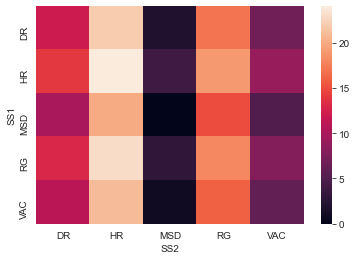

In [97]:
sns.heatmap(df)

In [58]:
type(data_VAC_MSD)

pyabc.storage.history.History

In [82]:
def HeatMap_function(df, title, transpose = True, colors = 'Greens', dropDuplicates = True):

    if transpose:
        df = df.T
    
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask = np.invert(mask)
        mask[np.triu_indices_from(mask)] = False

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    ax.set_title(title)
  
    # Add diverging colormap from red to blue
    # cmap = sns.diverging_palette(250, 10, as_cmap=True)
    cmap=plt.get_cmap(colors)
    
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, annot=True, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, annot=True, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('right')


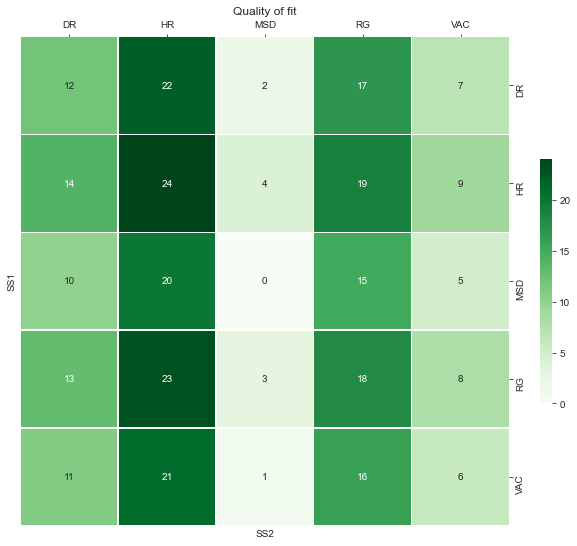

In [99]:
HeatMap_function(df = df, title = 'Quality of fit', transpose = False,
                 colors = 'Greens', dropDuplicates = False)

In [251]:
np.random.seed(0)

In [252]:
df

name,motion_strength,noise_level
id,,
9682,2.879159,0.042109
9683,0.466828,0.826715
9684,0.716014,0.639628
9685,1.442559,0.013153
9686,0.954230,0.044028
...,...,...
9777,2.007175,0.061286
9778,1.993825,0.446857
9779,1.110446,0.382391


## Save the data:

In [ ]:
# First save as dataframes with 